## Dorien Simon
## Fred Hutchinson Cancer Center
## Project Description:
### The point of this project is to accurately calculate the expected number of transitions between states (between regions) in a given amount of time. Minin & Suchard produced a paper with an equation that computes the number of expected transitions between states in a given amount of time. So the goal of this project is to make sure that the equation is properly implememnted into code. The equation is implemented in the 'expected_number_of_transitions_in_time_t' function. The remaining code is constructing a simulation that actually runs through a series of events and records the number of times certain events occur (which are the number of transitions). The other portion of the remaining code is creating several figures to understand how accurate the implementation of the equation was compared to the simulation. The implementation of the equation in this case was effective as the simulation yielded very similar results. 
Minin & Suchard paper: http://vnminin.github.io/papers/MininSuchard2009.pdf

### For all the figures to function normally, the following code needs to be run in Jupyer Lab

# All the packages that need to be imported 

In [2]:
import numpy as np
import scipy
from scipy import linalg
import pandas as pd
import altair as alt
import seaborn as sns

# Define the Q-Matrix that you will use for this experiment 

In [3]:
Q=np.fromstring("-0.8655 0.121 0.1864 0.337 0.0631 0.158 0.148 -0.8782 0.3739 0.1349 0.0632 0.1582 0.1461 0.2398 -1.0823 0.1333 0.4073 0.1558 0.3692 0.1209 0.1863 -1.0079 0.0947 0.2368 0.1468 0.1203 1.2085 0.201 -1.9125 0.2359 0.1471 0.1205 0.185 0.2012 0.0944 -0.7482", dtype=float, sep=" ").reshape(6,6)
Q

array([[-0.8655,  0.121 ,  0.1864,  0.337 ,  0.0631,  0.158 ],
       [ 0.148 , -0.8782,  0.3739,  0.1349,  0.0632,  0.1582],
       [ 0.1461,  0.2398, -1.0823,  0.1333,  0.4073,  0.1558],
       [ 0.3692,  0.1209,  0.1863, -1.0079,  0.0947,  0.2368],
       [ 0.1468,  0.1203,  1.2085,  0.201 , -1.9125,  0.2359],
       [ 0.1471,  0.1205,  0.185 ,  0.2012,  0.0944, -0.7482]])

# Below are all the functions that are needed 

In [6]:
np.random.seed(1)
def expected_number_of_transitions_in_time_t_final(array_step, Q):
    """This function returns a Matrix of the expected number of transitions between states 
    in a given amount of time. 
    This is a program that was generated from the Minin and Suchard equation. 
    array_step = the time step. It can be a float or int.
    Q = The rate matrix. This is the rate matrix that was defined above."""
    eigenvalue,eigenvector = np.linalg.eig(Q)
    eigenvector_inv = np.linalg.inv(eigenvector)
    E_n = np.zeros_like(Q)
    for i in range(Q.shape[0]):
        d_i=eigenvalue[i]
        E_i = np.zeros_like(Q)
        E_i[i,i]=1
        S_i = eigenvector @ E_i @ eigenvector_inv
        for j in range(Q.shape[0]):
            d_j=eigenvalue[j]
            E_j = np.zeros_like(Q)
            E_j[j,j]=1
            S_j= eigenvector @ E_j @ eigenvector_inv           
            if d_i == d_j:
                I_ij = array_step * np.exp(d_i*array_step)
            else: 
                I_ij = (np.exp(d_i*array_step) - np.exp(d_j*array_step)) / (d_i - d_j)
            N_greek=S_i @ Q @ S_j * I_ij
            E_n += N_greek         
    return E_n

In [8]:
np.random.seed(3)
def simulated_number_of_transitions(array_step, first, last, Q):
    """This function returns a sinlge value for the number of counted transitions between 
    the first and last state in a given amount of time.
    The purpose of this function is to get the actual number of transitions in a given time. 
    The simulation runs through a series of events and records how many times a certain event/series happened.
    array_step = time step.
    Q = the rate matrix defined earlier in the code.
    first = the starting state
    last = the ending state"""
    Q_array=np.array(Q)
    Q_exponential=scipy.linalg.expm(Q*1000)
    probability_distribution = Q_exponential[0]
    transitions=[]
    state_amount=Q.shape[0]
    for simulation_trials in range(5000):
        states=[]
        time_passed=0
        first_state=np.random.choice(state_amount, 1, p=probability_distribution)
        #This is necessary to convert the first_state 'array' into an integer
        state=int("".join(map(str, first_state)))
        while time_passed < array_step:
            new_time = np.random.exponential(1/Q_array[state, (Q_array[state] >= 0)].sum())
            time_passed += new_time
            new_state = np.random.choice(state_amount, 1, p=probability_distribution)
            states.append(new_state)
            #This looks at the last state in the array list of states
            current_state=states[-1]
            if (first_state == first and current_state == last):
                transitions.append(states)
    return float ((len(transitions))/5000.0)

In [9]:
def simulated_Q_Matrix(array_step):
    """This function returns a Matrix of the actaul number 
    of recorded transitions between states from the simulation.
    The purpose of this function is to convert the "simulated number 
    of transitions function" that's above into a matrix.
    array_step = a time step"""
    simulated_Q_array = []
    size=Q.shape[0]
    for i in range(Q.shape[0]):
        first = i
        for j in range(Q.shape[0]):
            last = j
            cell_value = simulated_number_of_transitions(array_step, first, last, Q)
            if(first == i and last == j):
                simulated_Q_array.append(cell_value)
    simulated_Q_matrix = np.reshape(simulated_Q_array, (size,size))
    return simulated_Q_matrix

# ALL HEAT MAPS SHOULD HAVE SAME TIME STEP

# __________________________________________________________________________________________________________________________ 

## Simulated Number of Transitions Heat Map 
### This heatmap should have no negative values. Ignoring the diagonal ii-th entries, the ij-th entries shoud all be reasonably close to the values in the Expected Number of Transitions Heat Map below. To further evaluate how close the values are will be done in a later step.

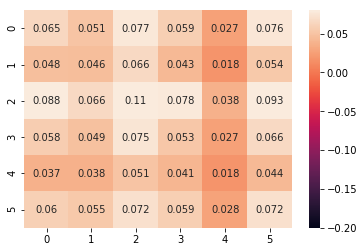

In [10]:
sns.heatmap(simulated_Q_Matrix(1), vmin=-0.20, vmax=0.08, annot=True, )

## Expected Number of Transitions Heat Map
### This heat map should have negatives on the diagonal (the ii-th entries). These values are the number of transitions FROM that state. So if you were to add up all the rows they should add up to zero across. If there are negatives in any of the ij-th entries, then there may be an issue in the Q Matrix that was entered into the function, the time step is too large, or it's just noise from the calculataions and you can ignore it for the time being. Not quite sure what all reasons could cause this phenomena or how to solve such issues, but it is ok to proceed with the remaining steps.

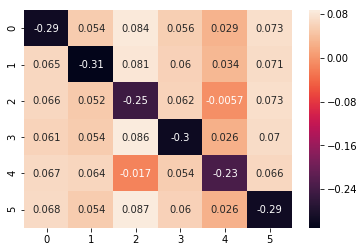

In [11]:
sns.heatmap(expected_number_of_transitions_in_time_t_final(1, Q), annot=True)

## The Difference of Simulated and Expected Number of Transitions Heat Map
### This heat map should be relatively light colored on the ii-th entry diagonals since the Simulated Heat Map should be producing only positive values and the Expected Heat Map should have negatives along the ii-th entry diagonal. The rest of the cells should be quite dark, signaling that the two matrices are similar since their difference are nearly zero. If the cells are all light colored, the implementation of the equation is not useful for this time step, or the simulation is not accurate to this time step. This is the motivation for the following code that tests how close the simulation and expectations from the equation are. It helps determine what time steps produce the most accurate measurements. 

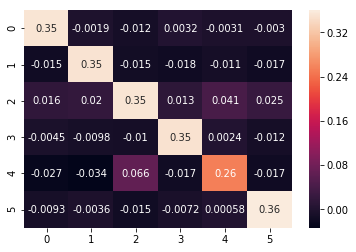

In [12]:
difference_in_transitions = simulated_Q_Matrix(1) - expected_number_of_transitions_in_time_t_final(1, Q)
sns.heatmap(difference_in_transitions, annot=True)

## The Difference Data Frame
### I found the difference of the two matrices (simulated number of transitions and expected number of transitions) and converted the data of the differences over certain lengths of time into a Data Frame. The point of forming the data frame was to create a graph to better visualize the closeness of the values in the matrices.

In [ ]:
data_matrix = []
array = np.arange(0.1, 2, 0.1)
for t in array:
    array_step = t
    difference_in_transitions = simulated_Q_Matrix(array_step) - expected_number_of_transitions_in_time_t_final(array_step, Q)
    for i in range(Q.shape[0]):
        for j in range(Q.shape[0]):
            #This step is necessary to help distinguish the two main patterns in the graph: ii-th entries and ij-th entries
            diagonal = "ii_entry"
            if(i == j):
                diagonal = "ii_entry"
            else:
                diagonal = "ij_entry"
            data_values = {'Time': array_step, 'Start State': [i], 'End State': [j], 'Difference': difference_in_transitions[i,j],'cell': diagonal}
            data_matrix.append(data_values)
difference_df= pd.DataFrame(data=data_matrix, columns=['Time','Start State','End State','Difference', 'cell'])
difference_df[0:10]

## Scatter Plot of the Difference Between the Simulated and Expected Number of Transitions
### Ignore the blue dots as they are the differences between the ii-th entries of the two matrices and as stated earlier, are expected to be high. The orange dots however should be clustered along the line of a difference of zero. It is ok if there is an increase of difference as time gets smaller or larger as this could be due to the limits of the simulation. There may be outlying patterns that do not fall in the general pattern of the ii-th entries (clustered along high differences) or of the majority of the ij-th entries (clustered along a difference of 0). This may be due to the noise of the random function and possible inaccuracies in both matrices in given time steps. 

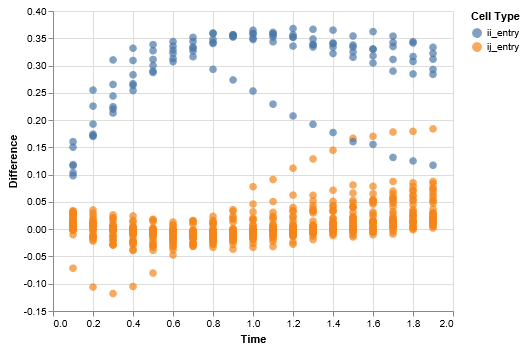

In [35]:
alt.Chart(difference_df).mark_circle(size=60).encode(
    x='Time',
    y='Difference',
    tooltip=['Difference', 'Start State', 'End State', 'Time'],
    color=alt.Color('cell', legend=alt.Legend(title="Cell Type"))
).interactive()